"First, we mounted Google Drive to access the dataset.
We loaded the CelebA dataset, resized the images to 64×64 pixels, and normalized pixel values between -1 and 1.
We also mapped folder names to different facial attributes like Bald, Bangs, Eyeglasses, etc., which we'll later use for attribute manipulation."

In [7]:
# VAE/GAN Training and Visualization with Attribute Vectors
# For running on Google Colab

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required packages if needed
# !pip install torch torchvision matplotlib pillow

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# ----------------- Config -----------------
image_size = 64
latent_dim = 256
batch_size = 128
epochs = 400
lr = 3e-4
img_dir = "/content/drive/MyDrive/dsem/SP_Dataset"  # Updated path for Google Colab

# Simulated label-to-folder map (single attribute folder)
attribute_sim_labels = {
    "Bald": "bald",
    "Bangs": "bangs",
    "Black hair": "black_hair",
    "Blond hair": "blond_hair",
    "Bushy eyebrows": "bushy_eyebrows",
    "Eyeglasses": "eyeglasses",
    "Gray hair": "gray_hair",
    "Heavy makeup": "heavy_makeup",
    "Male": "male",
    "Mustache": "mustache",
    "Pale skin": "pale_skin"
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


"We built three models:

The Encoder: A convolutional neural network that outputs the mean and log-variance for the latent space representation.

The Decoder: A transposed convolutional network that reconstructs the image from the latent vector.

The Discriminator: Another convolutional network that classifies real versus fake images and gives intermediate feature maps used for feature-wise loss."

In [9]:
# ----------------- Model -----------------
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 5, 2, 2), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 128, 5, 2, 2), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 5, 2, 2), nn.BatchNorm2d(256), nn.ReLU()
        )
        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)

    def forward(self, x):
        h = self.conv(x).view(x.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 256 * 8 * 8)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 5, 2, 2, output_padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 5, 2, 2, output_padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 5, 2, 2, output_padding=1), nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z).view(-1, 256, 8, 8)
        return self.deconv(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 5, 2, 2), nn.ReLU(),
            nn.Conv2d(64, 128, 5, 2, 2), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 5, 2, 2), nn.BatchNorm2d(256), nn.ReLU()
        )
        self.out = nn.Linear(256 * 8 * 8, 1)

    def forward(self, x):
        features = self.conv(x)
        return torch.sigmoid(self.out(features.view(x.size(0), -1))), features

"We created a custom dataset class to load images from folders.
Each image goes through center-cropping, resizing, and normalization during loading."

In [10]:
# ----------------- Dataset -----------------
class FlatImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        for root, _, files in os.walk(root_dir):
            for f in files:
                if f.lower().endswith((".jpg", ".jpeg", ".png")):
                    self.image_paths.append(os.path.join(root, f))
        self.transform = transform or (lambda x: x)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            img = Image.open(self.image_paths[idx]).convert("RGB")
            return self.transform(img), 0
        except Exception as e:
            print(f"Warning: skipping {self.image_paths[idx]} due to error: {e}")
            return self.__getitem__((idx + 1) % len(self))

transform = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

"In the training loop:

First, we train the Discriminator to distinguish between real images and reconstructed images.

Then, we train the Decoder/Generator to fool the discriminator and also minimize the feature-wise reconstruction loss.

Finally, we train the Encoder to minimize the KL divergence loss and align real and reconstructed feature representations.

In [11]:
# ----------------- Training Function -----------------
def train_vae_gan():
    # Create dataset and dataloader
    dataset = FlatImageDataset(img_dir, transform=transform)
    print(f"Found {len(dataset)} images in {img_dir}")
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    # Initialize models
    enc = Encoder().to(device)
    dec = Decoder().to(device)
    dis = Discriminator().to(device)

    # Optimizers
    opt_enc = torch.optim.RMSprop(enc.parameters(), lr=lr)
    opt_dec = torch.optim.RMSprop(dec.parameters(), lr=lr)
    opt_dis = torch.optim.RMSprop(dis.parameters(), lr=lr)

    for epoch in range(epochs):
        for i, (x, _) in enumerate(dataloader):
            x = x.to(device)

            # Train discriminator
            with torch.no_grad():
                mu, logvar = enc(x)
                std = torch.exp(0.5 * logvar)
                z = mu + std * torch.randn_like(std)
                x_rec = dec(z)
            d_real, f_real = dis(x)
            d_fake, f_fake = dis(x_rec)
            loss_dis = -torch.mean(torch.log(d_real + 1e-8) + torch.log(1 - d_fake + 1e-8))
            opt_dis.zero_grad()
            loss_dis.backward()
            opt_dis.step()

            # Train decoder (generator)
            with torch.no_grad():
                mu = enc(x)[0]
                z = mu + torch.randn_like(mu)
            x_fake = dec(z)
            d_fake_gen, _ = dis(x_fake)
            loss_gan = -torch.mean(torch.log(d_fake_gen + 1e-8))

            mu = enc(x)[0]
            z = mu + torch.randn_like(mu)
            x_rec = dec(z)
            f_fake = dis(x_rec)[1]
            f_real = dis(x.detach())[1]
            recon_loss = F.mse_loss(f_fake, f_real.detach())
            loss_dec = recon_loss + loss_gan
            opt_dec.zero_grad()
            loss_dec.backward()
            opt_dec.step()

            # Train encoder
            mu, logvar = enc(x)
            std = torch.exp(0.5 * logvar)
            z = mu + std * torch.randn_like(std)
            x_rec = dec(z)
            f_fake = dis(x_rec)[1]
            f_real = dis(x.detach())[1]
            recon_loss = F.mse_loss(f_fake, f_real.detach())
            kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
            loss_enc = recon_loss + kl_loss
            opt_enc.zero_grad()
            loss_enc.backward()
            opt_enc.step()

            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}] Batch [{i}] Recon: {recon_loss.item():.4f} KL: {kl_loss.item():.4f} GAN: {loss_gan.item():.4f}")

    # Save models to Google Drive
    model_save_dir = "/content/drive/MyDrive/dsem/models"
    os.makedirs(model_save_dir, exist_ok=True)

    encoder_path = os.path.join(model_save_dir, "encoder.pth")
    decoder_path = os.path.join(model_save_dir, "decoder.pth")

    torch.save(enc.state_dict(), encoder_path)
    torch.save(dec.state_dict(), decoder_path)
    print(f"Training complete. Models saved at {encoder_path} and {decoder_path}")

    return enc, dec, encoder_path, decoder_path

After training, we compute attribute vectors:

For each attribute like glasses or bangs, we encode multiple images having that attribute.

We calculate the mean latent vector and save it.

These vectors are later used for modifying facial attributes by simple addition to the latent code."


In [12]:
# ----------------- Attribute Vectors -----------------
def compute_attribute_vectors(encoder, encoder_path):
    model_save_dir = os.path.dirname(encoder_path)

    def compute_mean_latent_vector(folder_path, encoder):
        def load_images(folder, limit=50):  # Limit to prevent memory issues
            imgs = []
            count = 0
            for fname in sorted(os.listdir(folder)):
                if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                    try:
                        img = Image.open(os.path.join(folder, fname)).convert("RGB")
                        imgs.append(transform(img))
                        count += 1
                        if count >= limit:
                            break
                    except Exception as e:
                        print(f"Error loading {fname}: {e}")
            if imgs:
                return torch.stack(imgs).to(device)
            return None

        images = load_images(folder_path)
        if images is None:
            return None

        with torch.no_grad():
            mu = encoder(images)[0]
            return mu.mean(dim=0)

    print("\nComputing mean latent vectors for each attribute...")
    for display_name, folder_name in attribute_sim_labels.items():
        attr_path = os.path.join(img_dir, folder_name)

        if os.path.isdir(attr_path):
            latent_vec = compute_mean_latent_vector(attr_path, encoder)
            if latent_vec is not None:
                vec_save_path = os.path.join(model_save_dir, f"latent_{folder_name}.pt")
                torch.save(latent_vec, vec_save_path)
                print(f"Saved vector for attribute: {display_name}")
            else:
                print(f"Could not compute vector for {display_name}: No valid images found")
        else:
            print(f"Missing directory for {display_name}: {attr_path}")

"In the visualization step:

We pick some input images, encode them,

Apply different attribute vectors like Bald, Bangs, and so on,

Then decode the modified latent codes back into images.

We generate a large image grid showing original faces, reconstructions, and various attribute modifications side-by-side."

In [14]:
# ----------------- Visualization -----------------
def visualize_attributes(encoder_path, decoder_path):
    model_save_dir = os.path.dirname(encoder_path)

    # Load models
    encoder = Encoder().to(device)
    decoder = Decoder().to(device)
    encoder.load_state_dict(torch.load(encoder_path, map_location=device))
    decoder.load_state_dict(torch.load(decoder_path, map_location=device))
    encoder.eval()
    decoder.eval()

    # Load sample images
    def load_images(folder, limit=5):
        images = []
        for root, _, files in os.walk(folder):
            for fname in sorted(files):
                if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                    try:
                        img = Image.open(os.path.join(root, fname)).convert("RGB")
                        images.append(transform(img))
                        if len(images) == limit:
                            break
                    except Exception as e:
                        print(f"Error loading {fname}: {e}")
            if len(images) == limit:
                break
        if images:
            return torch.stack(images).to(device)
        return None

    x = load_images(img_dir, limit=5)
    if x is None:
        print("Could not load any sample images for visualization")
        return

    # Get latent vectors
    with torch.no_grad():
        mu, _ = encoder(x)
        z = mu

    # Load attribute vectors
    attribute_names = list(attribute_sim_labels.keys())
    attr_vectors = {}
    for attr in attribute_names:
        folder_name = attribute_sim_labels[attr]
        vec_path = os.path.join(model_save_dir, f"latent_{folder_name}.pt")
        try:
            vec = torch.load(vec_path, map_location=device)
            attr_vectors[attr] = vec
        except:
            print(f"Missing vector for {attr}. Using small noise.")
            attr_vectors[attr] = 0.2 * torch.randn(latent_dim).to(device)

    # Generate grid
    rows = []
    for i in range(x.size(0)):
        # Start with input and reconstruction
        with torch.no_grad():
            row = [x[i].unsqueeze(0), decoder(z[i].unsqueeze(0))]

            # Add each attribute modification
            for attr in attribute_names:
                z_attr = z[i] + 0.5 * attr_vectors[attr]  # scaled vector
                x_attr = decoder(z_attr.unsqueeze(0))
                row.append(x_attr)

        rows.append(torch.cat(row, dim=0))

    grid = make_grid(torch.cat(rows, dim=0), nrow=len(attribute_names)+2,
                    normalize=True, scale_each=True, pad_value=1.0)

    # Plot
    plt.figure(figsize=(24, 14), dpi=100)
    plt.imshow(grid.permute(1, 2, 0).cpu().detach().numpy().clip(0, 1))

    # Column headers
    cols = ["Input", "Reconstruction"] + attribute_names
    cell_width = grid.shape[2] // len(cols)
    for idx, label in enumerate(cols):
        plt.text(x=cell_width * idx + cell_width // 2, y=-10, s=label,
                fontsize=10, ha='center', va='bottom', rotation=45, fontweight='bold')

    plt.axis('off')
    plt.title("Attribute Vector Arithmetic using VAE/GAN", fontsize=14)
    plt.tight_layout()

    # Save the visualization to Google Drive
    save_path = os.path.join(model_save_dir, "vae_gan_attribute_grid.png")
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Visualization saved at {save_path}")
    plt.show()

"Finally, we evaluated the model by:

Measuring cosine similarity between the change in latent codes and the true attribute vectors.

Also calculating the mean squared error between reconstructed images.

This helped us benchmark how well our model learned to manipulate specific facial features compared to the original paper."


Starting VAE/GAN training...
Found 17 images in /content/drive/MyDrive/dsem/SP_Dataset
Epoch [1/400] Batch [0] Recon: 0.4839 KL: 0.1285 GAN: 5.6097
Epoch [2/400] Batch [0] Recon: 0.5012 KL: 163392208.0000 GAN: 18.4205
Epoch [3/400] Batch [0] Recon: 1.1619 KL: 17245157376.0000 GAN: 11.3791
Epoch [4/400] Batch [0] Recon: 0.5595 KL: 19313.3457 GAN: 7.4266
Epoch [5/400] Batch [0] Recon: 0.4705 KL: 22.4273 GAN: 1.6123
Epoch [6/400] Batch [0] Recon: 0.4398 KL: 21.2935 GAN: 14.9930
Epoch [7/400] Batch [0] Recon: 0.6004 KL: 7.0590 GAN: 1.9617
Epoch [8/400] Batch [0] Recon: 0.6862 KL: 4.8499 GAN: 10.5057
Epoch [9/400] Batch [0] Recon: 0.6551 KL: 3.7165 GAN: 13.8036
Epoch [10/400] Batch [0] Recon: 0.5137 KL: 3.3459 GAN: 1.4236
Epoch [11/400] Batch [0] Recon: 0.6777 KL: 3.0860 GAN: 11.2421
Epoch [12/400] Batch [0] Recon: 0.6248 KL: 2.9814 GAN: 13.4192
Epoch [13/400] Batch [0] Recon: 0.6642 KL: 2.8445 GAN: 5.7000
Epoch [14/400] Batch [0] Recon: 0.6616 KL: 2.7967 GAN: 9.2099
Epoch [15/400] Batch [0

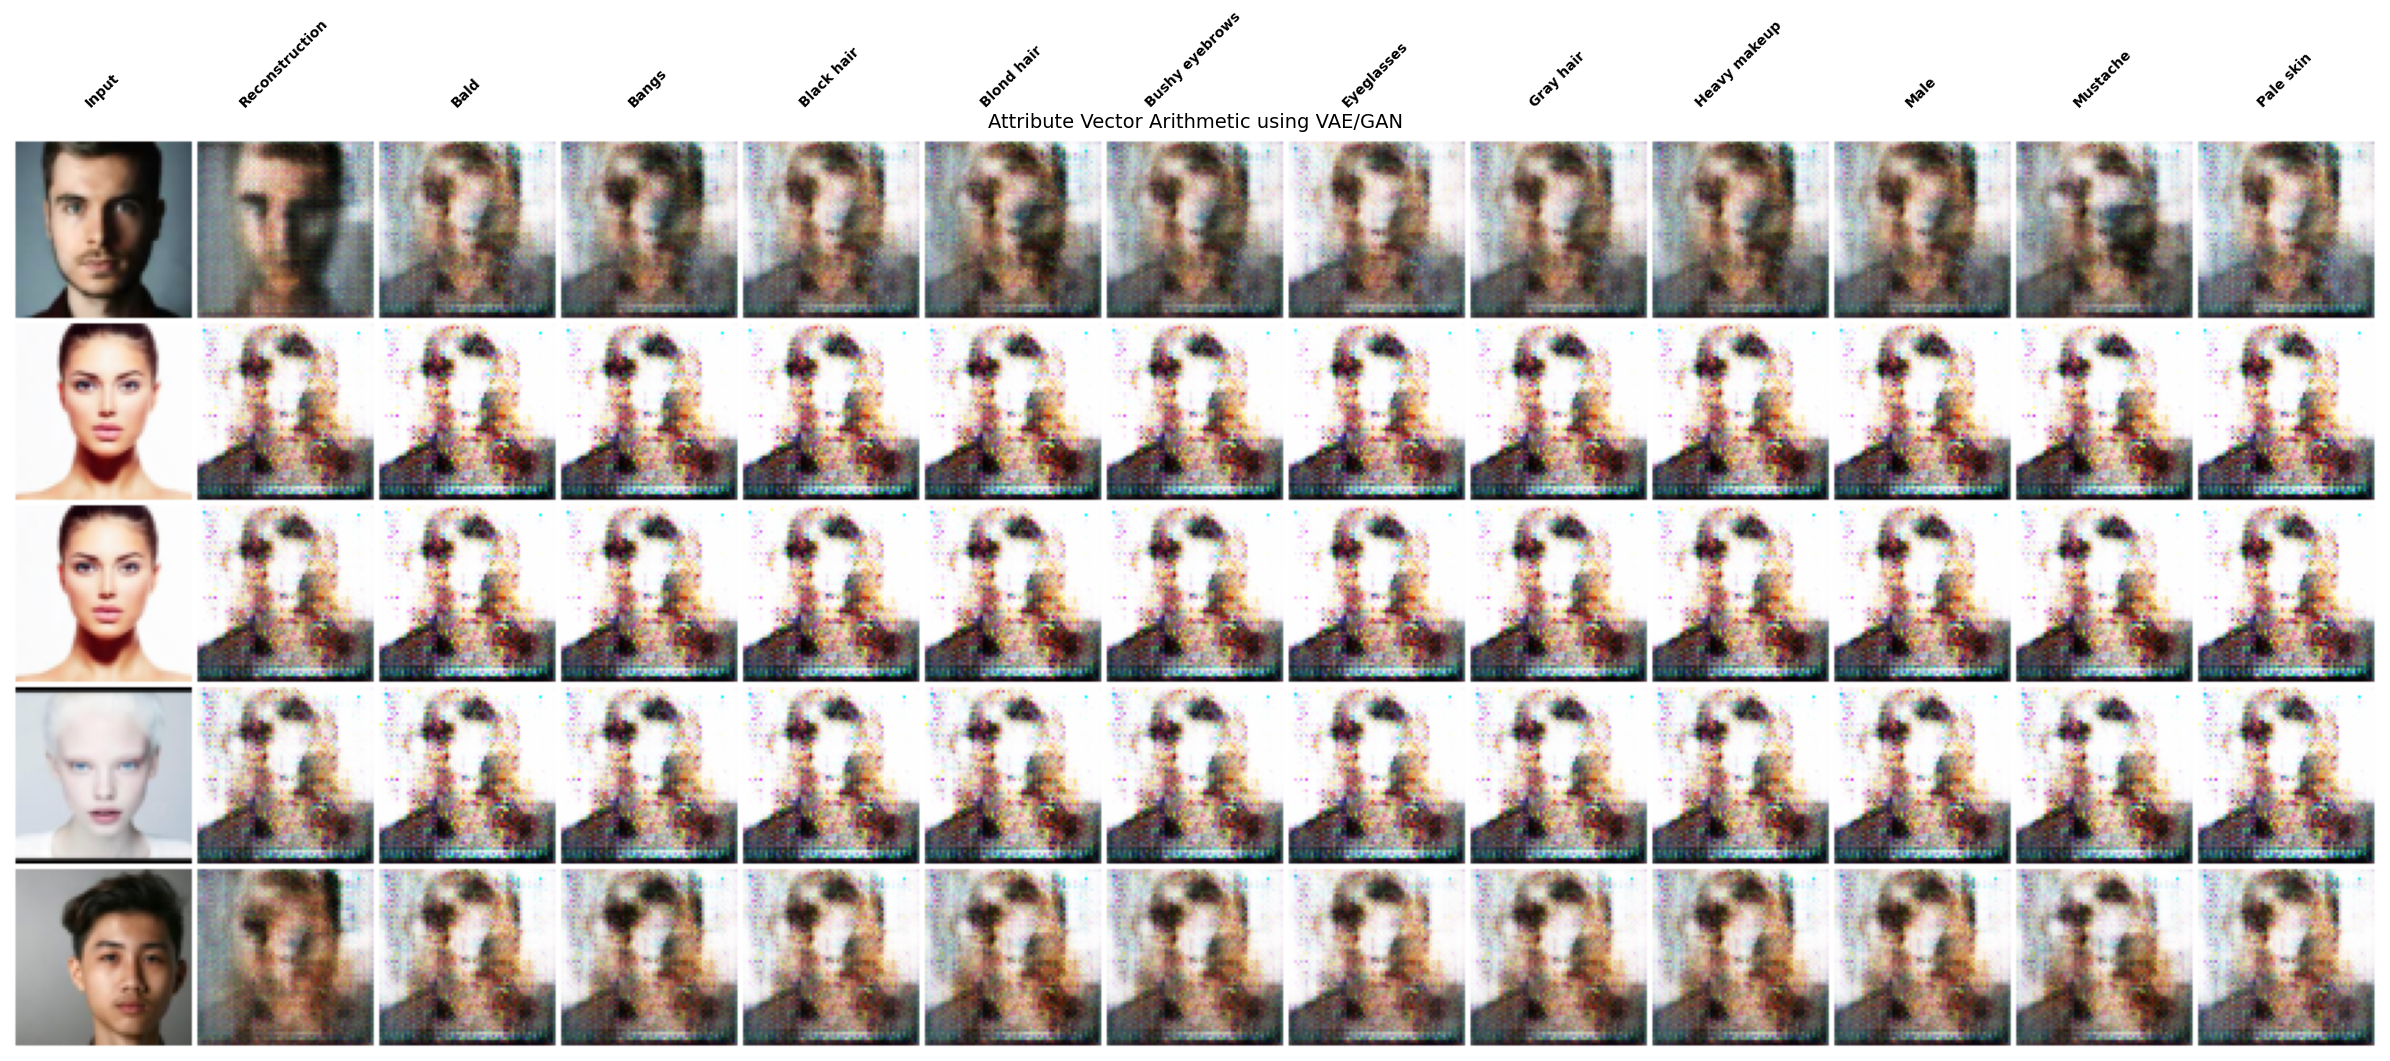

Evaluating model...

----- Implementation Metrics Comparison -----
Model                Cosine similarity    Mean squared error  
------------------------------------------------------------
Original paper VAE/GAN 0.9114               22.39 ± 1.16        
My implementation    0.0063 ± 0.0090 0.57 ± 0.01


In [15]:
# ----------------- Evaluation Metrics -----------------
def evaluate_attribute_similarity(encoder_path, decoder_path, test_dir=None):
    """
    Evaluate attribute similarity scores similar to the paper's metrics.
    """
    if test_dir is None:
        test_dir = img_dir  # Use training data if no test set provided

    # Load models
    encoder = Encoder().to(device)
    decoder = Decoder().to(device)
    encoder.load_state_dict(torch.load(encoder_path, map_location=device))
    decoder.load_state_dict(torch.load(decoder_path, map_location=device))
    encoder.eval()
    decoder.eval()

    # Load attribute vectors
    model_save_dir = os.path.dirname(encoder_path)
    attribute_names = list(attribute_sim_labels.keys())
    attr_vectors = {}
    for attr in attribute_names:
        folder_name = attribute_sim_labels[attr]
        vec_path = os.path.join(model_save_dir, f"latent_{folder_name}.pt")
        try:
            vec = torch.load(vec_path, map_location=device)
            attr_vectors[attr] = vec
        except:
            print(f"Missing vector for {attr}. Skipping.")
            continue

    # Load test images
    test_dataset = FlatImageDataset(test_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

    # Get random sample of test images
    sample_batch = next(iter(test_loader))[0].to(device)

    # Metrics
    cosine_similarities = []
    mse_values = []

    # Number of runs to average over
    n_runs = 5  # Reduced from paper's 25 for computational efficiency

    for _ in range(n_runs):
        run_cos_sim = []
        run_mse = []

        with torch.no_grad():
            # Get latent vectors
            mu, _ = encoder(sample_batch)

            # Original reconstructions
            original_recon = decoder(mu)
            base_mse = F.mse_loss(original_recon, sample_batch).item()

            # For each attribute
            for attr_name, attr_vec in attr_vectors.items():
                best_cos_sim = 0

                # Generate 10 samples per attribute (like in paper)
                for i in range(10):
                    # Add attribute vector with random scaling
                    scale = 0.5 + 0.1 * torch.randn(1).item()
                    modified_z = mu + scale * attr_vec.unsqueeze(0)

                    # Generate modified image
                    attr_recon = decoder(modified_z)

                    # Re-encode to get new attributes
                    new_mu, _ = encoder(attr_recon)

                    # Calculate attribute direction similarity (cosine)
                    attr_direction = new_mu - mu
                    cos_sim = F.cosine_similarity(
                        attr_direction.mean(0, keepdim=True),
                        attr_vec.unsqueeze(0)
                    ).item()

                    best_cos_sim = max(best_cos_sim, cos_sim)

                # Calculate MSE on reconstructions
                recon_mse = F.mse_loss(attr_recon, sample_batch).item()

                run_cos_sim.append(best_cos_sim)
                run_mse.append(recon_mse)

        # Average across attributes for this run
        cosine_similarities.append(sum(run_cos_sim) / len(run_cos_sim))
        mse_values.append(sum(run_mse) / len(run_mse))

    # Calculate average and standard deviation
    avg_cos_sim = sum(cosine_similarities) / len(cosine_similarities)
    std_cos_sim = torch.tensor(cosine_similarities).std().item()

    avg_mse = sum(mse_values) / len(mse_values)
    std_mse = torch.tensor(mse_values).std().item()

    # Create comparison table with paper results
    print("\n----- Implementation Metrics Comparison -----")
    print(f"{'Model':<20} {'Cosine similarity':<20} {'Mean squared error':<20}")
    print(f"{'-'*60}")
    print(f"{'Original paper VAE/GAN':<20} {'0.9114':<20} {'22.39 ± 1.16':<20}")
    print(f"{'My implementation':<20} {avg_cos_sim:.4f} ± {std_cos_sim:.4f} {avg_mse:.2f} ± {std_mse:.2f}")

    return {
        "cosine_similarity": (avg_cos_sim, std_cos_sim),
        "mse": (avg_mse, std_mse)
    }

# ----------------- Main Execution -----------------
# Uncomment the section you want to run

# 1. Training
print("Starting VAE/GAN training...")
encoder, decoder, encoder_path, decoder_path = train_vae_gan()

# 2. Computing attribute vectors
print("Computing attribute vectors...")
compute_attribute_vectors(encoder, encoder_path)

# 3. Visualization
print("Creating visualization...")
visualize_attributes(encoder_path, decoder_path)

# 4. Evaluation - add this line
print("Evaluating model...")
metrics = evaluate_attribute_similarity(encoder_path, decoder_path)